<a href="https://colab.research.google.com/github/Youngboss45/sql-server-samples/blob/master/Telco%20Customer%20Churn%20%26%20Retention%20Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the dataset

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [66]:
(df.isnull().sum())

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [67]:
df.drop_duplicates(inplace=True)

In [68]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()

In [69]:
# Fix TotalCharges (convert to numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


In [70]:
df['TotalCharges'].isnull().sum()


np.int64(11)

In [97]:
# Handle missing TotalCharges
# Customers with tenure = 0 had blank TotalCharges -> set to 0
df.loc[(df["tenure"] == 0) & (df["TotalCharges"].isna()), "TotalCharges"]

,TotalCharges


In [98]:
# Fill any remaining NaN with median
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

In [99]:
# 5. Standardize gender
df["gender"] = df["gender"].str.title()  # "Male" / "Female"

In [101]:
# 6. Create numeric churn flag (0 = No, 1 = Yes)
df["ChurnFlag"] = df["Churn"].map({"No": 0, "Yes": 1})

EDA

In [102]:
# Set visualization style
sns.set(style="whitegrid", palette="Set2")

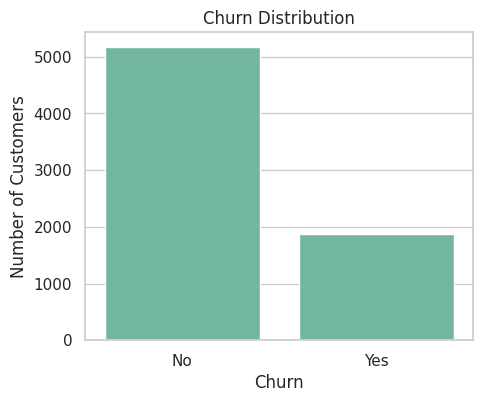

In [103]:
# === 1. Churn Distribution ===
plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.ylabel("Number of Customers")
plt.show()

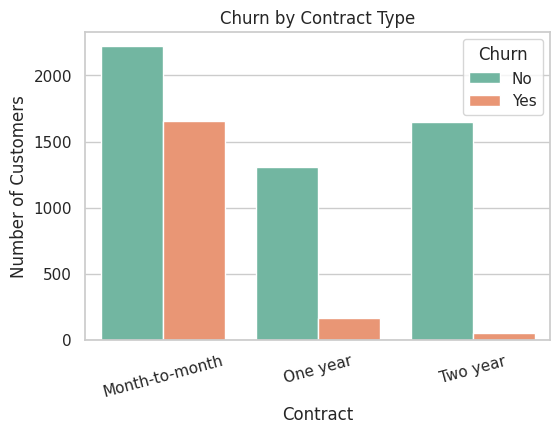

In [77]:
# === 2. Churn by Contract Type ===
plt.figure(figsize=(6,4))
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Churn by Contract Type")
plt.xticks(rotation=15)
plt.ylabel("Number of Customers")
plt.show()

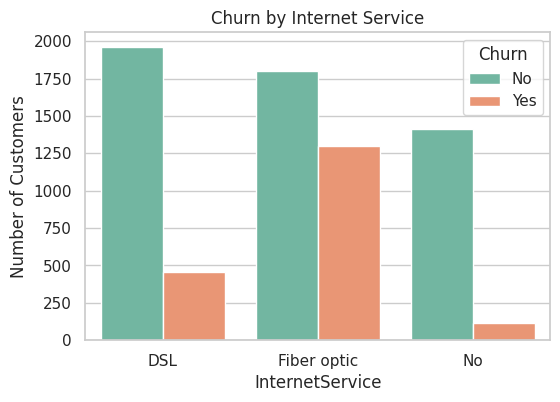

In [78]:
# === 3. Churn by Internet Service ===
plt.figure(figsize=(6,4))
sns.countplot(x="InternetService", hue="Churn", data=df)
plt.title("Churn by Internet Service")
plt.ylabel("Number of Customers")
plt.show()

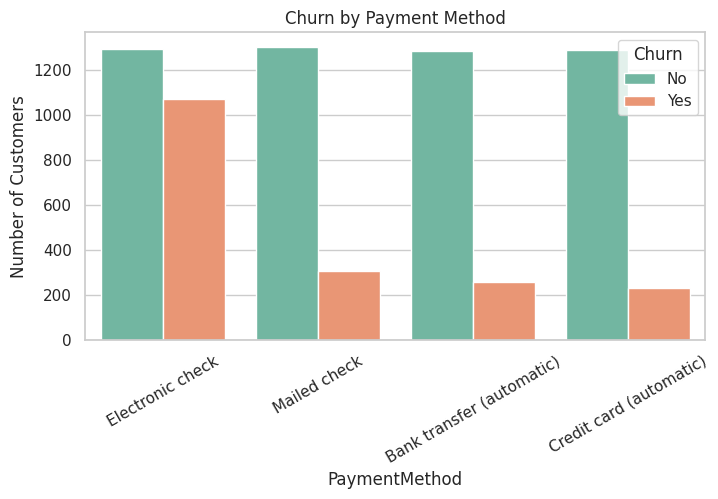

In [79]:
# === 4. Churn by Payment Method ===
plt.figure(figsize=(8,4))
sns.countplot(x="PaymentMethod", hue="Churn", data=df)
plt.title("Churn by Payment Method")
plt.xticks(rotation=30)
plt.ylabel("Number of Customers")
plt.show()


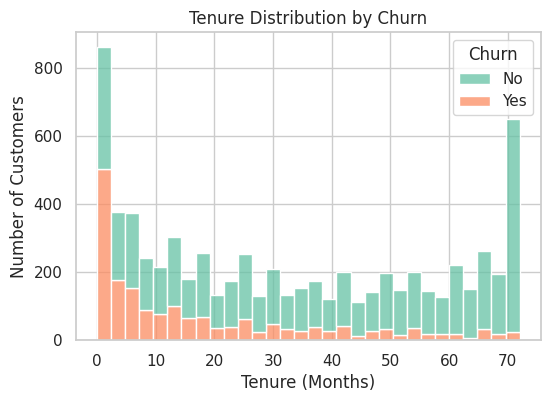

In [80]:
# === 5. Tenure vs Churn ===
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, multiple="stack")
plt.title("Tenure Distribution by Churn")
plt.xlabel("Tenure (Months)")
plt.ylabel("Number of Customers")
plt.show()


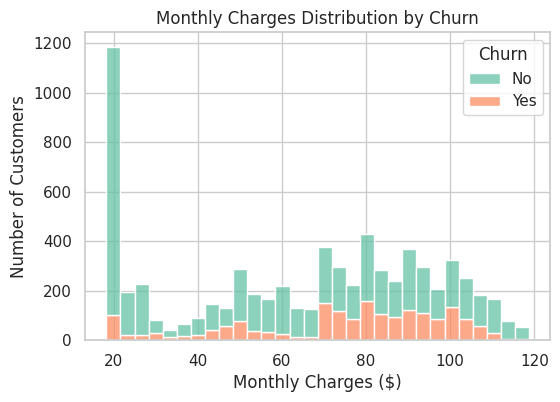

In [81]:
# === 6. Monthly Charges vs Churn ===
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="MonthlyCharges", hue="Churn", bins=30, multiple="stack")
plt.title("Monthly Charges Distribution by Churn")
plt.xlabel("Monthly Charges ($)")
plt.ylabel("Number of Customers")
plt.show()

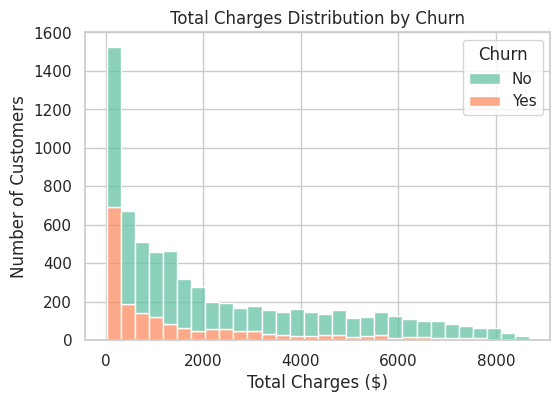

In [82]:
# === 7. Total Charges vs Churn ===
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="TotalCharges", hue="Churn", bins=30, multiple="stack")
plt.title("Total Charges Distribution by Churn")
plt.xlabel("Total Charges ($)")
plt.ylabel("Number of Customers")
plt.show()

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [104]:
#Define features (X) and target (y)
X = df.drop(["customerID", "Churn", "ChurnFlag"], axis=1)
y = df["ChurnFlag"]

In [106]:
# Separate numeric and categorical columns
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [col for col in X.columns if col not in numeric_features]

In [86]:
#Preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [87]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [88]:
#Logistic Regression pipeline
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])


In [89]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [107]:
# Fit model
clf.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [108]:
#Predictions & evaluation
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]


In [109]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[746 289]
 [ 81 293]]


In [110]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [111]:
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))


ROC-AUC Score: 0.8414063912785139


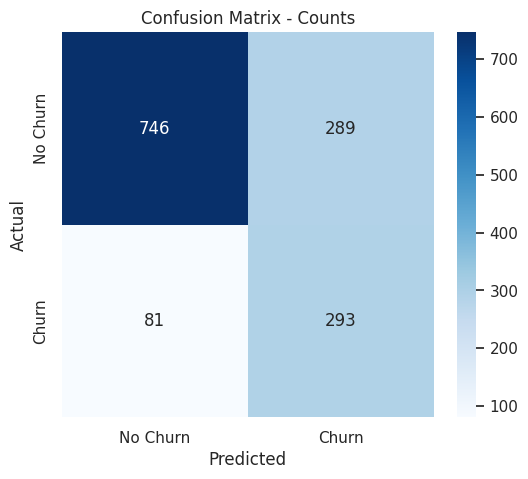

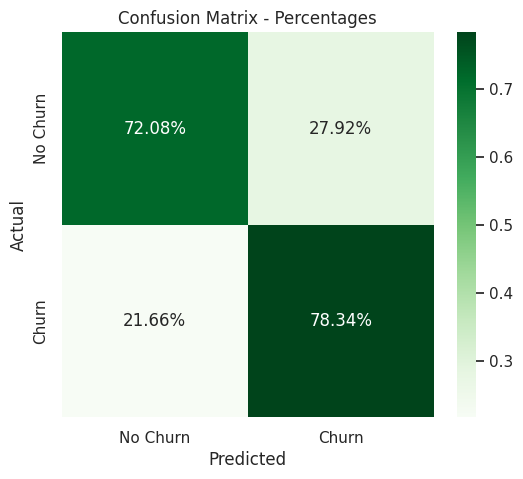

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Create figure
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn","Churn"],
            yticklabels=["No Churn","Churn"])
plt.title("Confusion Matrix - Counts")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot with percentages
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=["No Churn","Churn"],
            yticklabels=["No Churn","Churn"])
plt.title("Confusion Matrix - Percentages")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
